In [294]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from synthid_text.detector_frequentist import frequentist_score, weighted_frequentist_score
from scipy.stats import norm

In [295]:
MODEL_NAME = "meta-llama/Llama-3.1-8B-Instruct"
F_MODEL_NAME = MODEL_NAME.replace("/", "_")
TEMPERATURE = 0.5
ROC_NUM_POINTS = 1000
ROC_TOKEN_LIMIT = 200 #for second ROC curve where we only consider the first e.g. 200 tokens

In [296]:
padded_eli5_g_values = torch.load(f"../frequentist_experiment_data/eli5_g_values_{F_MODEL_NAME}_t={TEMPERATURE}_wm.pt", map_location=torch.device('cpu'))
padded_eli5_combined_mask = torch.load(f"../frequentist_experiment_data/eli5_combined_mask_{F_MODEL_NAME}_t={TEMPERATURE}_wm.pt", map_location=torch.device('cpu'))
eli5_perplexities = torch.load(f"../frequentist_experiment_data/eli5_perplexities_{F_MODEL_NAME}_t={TEMPERATURE}_wm.pt", map_location=torch.device('cpu'))

/var/folders/59/7skhmmps2b17ysy_h9b099zh0000gn/T/ipykernel_79213/3005011794.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  padded_eli5_g_values = torch.load(f"../freque

In [297]:
# Mean Response Length
torch.mean(torch.sum(padded_eli5_combined_mask, dim=1).double()).item()

508.88

In [298]:
# Perplexity
torch.exp(torch.tensor(np.sum(eli5_perplexities)) / len(padded_eli5_g_values)).item()

1.3012906312942505

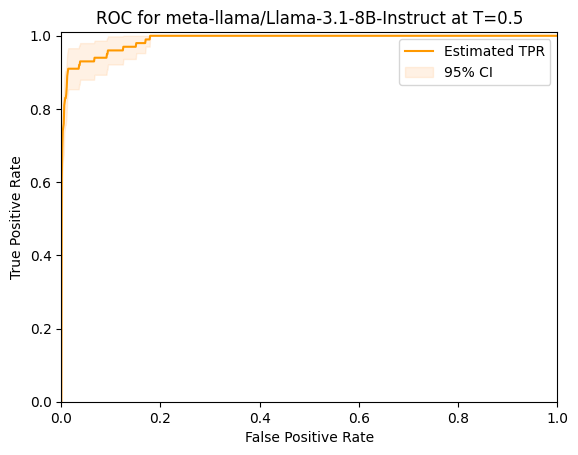

In [299]:
# ROC Curve

def ROC(freq_scores, title_suffix=""):
    # Given parameters
    fprs = np.linspace(0, 1, ROC_NUM_POINTS)

    # Compute TPR as proportion of samples that meet criterion at each FPR threshold
    tprs = np.array([
        np.sum(-freq_scores <= fpr) / len(freq_scores)
        for fpr in fprs
    ])

    # Sample size
    n = len(freq_scores)
    z = norm.ppf(0.975)  # ~1.96 for 95% CI

    # Compute standard error for each TPR
    se = np.sqrt((tprs * (1 - tprs)) / n)

    # Compute 95% confidence intervals
    tprs_lower = tprs - z * se
    tprs_upper = tprs + z * se

    # Bound the intervals between 0 and 1
    tprs_lower = np.clip(tprs_lower, 0, 1)
    tprs_upper = np.clip(tprs_upper, 0, 1)

    # Plot
    plt.plot(fprs, tprs, label='Estimated TPR', color='#ff9900')
    plt.fill_between(fprs, tprs_lower, tprs_upper, color='#ffbb78', alpha=0.2, label='95% CI')
    plt.title(f"ROC for {MODEL_NAME} at T={TEMPERATURE}{title_suffix}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.ylim(0, 1.01)
    plt.xlim(0, 1.0)
    plt.legend()

    plt.show()
    
eli5_freq_scores = frequentist_score(
    padded_eli5_g_values.cpu().numpy(),
    padded_eli5_combined_mask.cpu().numpy()
)
ROC(eli5_freq_scores)

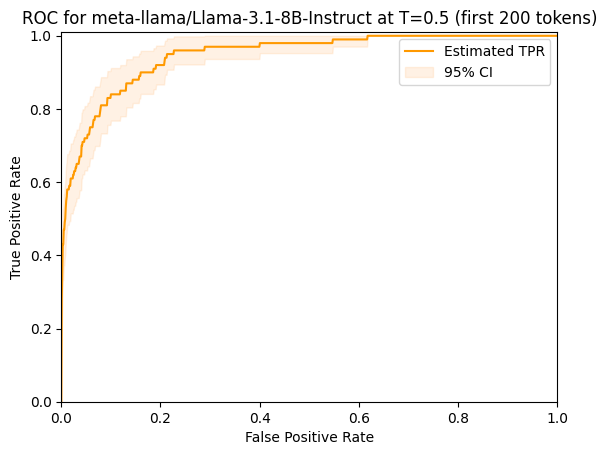

In [300]:
# ROC Curve for first ROC_TOKEN_LIMIT tokens
# To avoid having models that output more text getting better detectability

eli5_freq_scores_limited = frequentist_score(
    padded_eli5_g_values.cpu().numpy()[:,:ROC_TOKEN_LIMIT,:], padded_eli5_combined_mask.cpu().numpy()[:,:ROC_TOKEN_LIMIT]
)

ROC(eli5_freq_scores_limited, f" (first {ROC_TOKEN_LIMIT} tokens)")


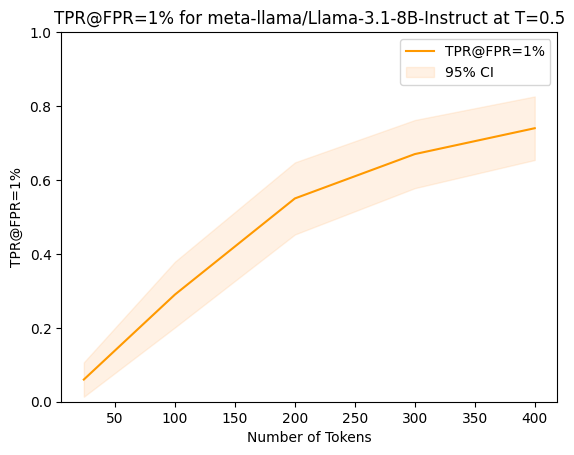

In [301]:
# True Positive at fixed False Positive Rate of 1%
# by token count, using same ones as in the paper (24 might not be exactly right)

token_counts = [24, 100, 200, 300, 400]

accs = []
lowers = []
uppers = []

z = norm.ppf(0.975)  # ~1.96 for 95% CI

for token_count in token_counts:
    freq_scores = frequentist_score(
        padded_eli5_g_values.cpu().numpy()[:, :token_count, :],
        padded_eli5_combined_mask.cpu().numpy()[:, :token_count]
    )
    n = len(freq_scores)
    acc = np.sum(-freq_scores <= 0.01) / n
    accs.append(acc)
    
    # Compute confidence interval
    se = np.sqrt((acc * (1 - acc)) / n)
    ci = z * se
    lower = max(0, acc - ci)
    upper = min(1, acc + ci)
    lowers.append(lower)
    uppers.append(upper)

accs = np.array(accs)
lowers = np.array(lowers)
uppers = np.array(uppers)

# Plot the accuracy line
plt.plot(token_counts, accs, label='TPR@FPR=1%', color='#ff9900')

# Fill the area between the lower and upper CI bounds
plt.fill_between(token_counts, lowers, uppers, color='#ffbb78', alpha=0.2, label='95% CI')

plt.title(f"TPR@FPR=1% for {MODEL_NAME} at T={TEMPERATURE}")
plt.xlabel("Number of Tokens")
plt.ylabel("TPR@FPR=1%")
plt.ylim(0, 1)
plt.legend()
plt.show()
